# TSA cycle of CO2 simulation example with a 1D Fixed Bed model
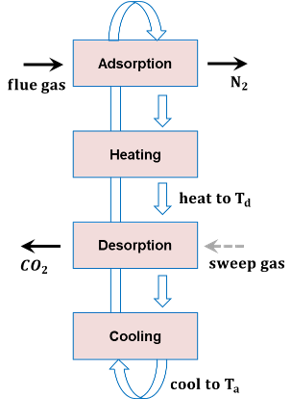

This jupyter notebook shows an example of a temperature swing adsorption and desorption of CO2 with the IDAES 1D FixedBed model. The IDAES 1D FixedBed model is a dynamic and axially varying reactor/adsorption model which is able to model the gas and solid interactions of the modeled species in detail. The sorbent used for this example is the NETL_32D sorbent with its details and parameters obtained from the following reference: 
- A. Lee, D.C. Miller, A One-Dimensional (1-D) Three-Region Model for a Bubbling Fluidized-Bed Adsorber, Ind. Eng. Chem. Res. 52 (2013) 469–484

The notebook demonstrates how to use the IDAES 1DFixedBed model for a TSA application with distinct adsorption and desorption steps, and also shows how to simulate the adsorption and desorption steps using the Petsc integrator.

## Cycle details
- Bed height: 9 m
- Bed diameter: 1 m
- Adsorption time: 30 hrs
- Desorption time: 2 hrs
- Adsorption temperature: 303.15 K
- Desorption temperature: 470 K
- Flue gas inlet conditions (Temperature and mole fractions obtained from NETL baseline report. Exhibit 5-22 B31B case)
    - Temperature: 315 K
    - Pressure: 106.5 kPa
    - Flowrate: 3.544 mol/s
    - Mole fractions: "CO2": 0.0408, "H2O": 0.0875, "N2": 0.7517, "O2": 0.12

# Step 1: Import relevant libraries and packages

### Import python libraries

- numpy (numerical python library which provides numerical computing tools)
- time (time python library which will be used to track the simulation time)

In [ ]:
import numpy as np
import time


### Import Pyomo pakages
For the flowsheet, we will need several components from the pyomo libraries.

- ConcreteModel (to create the Pyomo model that will contain the IDAES flowsheet)
- TransformationFactory (to apply certain transformations)
- SolverFactory (to solve the problem)
- Var (to create a Pyomo variable)
- value (to return the numerical value of an Pyomo objects such as variables, constraints or expressions)
- units (to handle units in Pyomo and IDAES)
- ContinuousSet (to create continuous sets in Pyomo for supporting the evaluation of integrals and derivatives)
- Integral (to calculate the integrals of variables of interest)

For further details on these components, please refer to the pyomo documentation: https://pyomo.readthedocs.io/en/latest/

In [ ]:
from pyomo.environ import (
    ConcreteModel,
    TransformationFactory,
    SolverFactory,
    Var,
    value,
    units as pyunits,
)
from pyomo.dae import ContinuousSet, Integral

### Import IDAES core components

To build, initialize, and solve IDAES flowsheets we will need several core components/utilities:

- FlowsheetBlock (the flowsheet block contains idaes properties, time, and unit models)
- EnergyBalanceType (to specify the energy balance type)
- petsc (petsc integrator)
- get_solver (IDAES solver utility)
- iscale (is used to apply scaling factors in variables and constraints)
- propagate_state (is used to initialize models, propagating the state variables from one unit model to another)
- degrees_of_freedom (useful for debugging, this method returns the DOF of the model)
- idaeslog (is used to set output messages like warnings or errors)

For further details on these components, please refer to the IDAES documentation: https://idaes-pse.readthedocs.io/en/latest/

In [ ]:
from idaes.core import FlowsheetBlock, EnergyBalanceType
import idaes.core.solvers.petsc as petsc  # petsc utilities module
from idaes.core.util import scaling as iscale
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.logger as idaeslog

### Import IDAES unit models and NETL 32D property packages

To build the IDAES flowsheet for the TSA example, we will need the following: 
1) the 1D Fixed Bed unit model.
2) the NETL 32D property package.

In [ ]:
# from idaes.models_extra.gas_solid_contactors.unit_models.fixed_bed_1D import FixedBed1D
from fixed_bed_1D import FixedBed1D  # TODO - remove when IDAES FixedBed1D PR is approved
from property_packages.gas_phase_thermo import GasPhaseParameterBlock
from property_packages.solid_phase_thermo import SolidPhaseParameterBlock
from property_packages.adsorption_reactions import HeteroReactionParameterBlock

### Import custom libraries and functions

- heat_computation (used to calculate the heat requirements of the TSA cycle)
- performance_results (used to evaluate the performance of the TSA cycle)
- results_summary (provides summarized results of the TSA cycle)
- plot_results_temporal (plots the temporal profiles of the flowsheet simulation)
- plot_results_spatial (plots the spatial profiles of the flowsheet simulation)
- fb_model_setup (function that builds the 1D FixedBed model)
- fb_fixed_conditions (function that fixes the initial and boundary conditions of the 1D FixedBed model)

In [ ]:
from simulation_utilities import (
    heat_computation,
    performance_results,
    results_summary,
    plot_results_temporal,
    plot_results_spatial
)

#### Function "fb_model_setup"

This function builds instances of the 1D FixedBed model for the adsorption and desorption simulations. As arguments it takes the following:
1) The flowsheet block of the simulation i.e. the adsorption flowsheet
2) The number of time finite elements
3) The number of spatial finite elements

It returns a flowsheet object which contains an instance of the 1D FixedBed model

In [ ]:
def fb_model_setup(
    fs,
    ntfe,  # number of time finite elements
    nxfe,  # number of space finite elements
):

    # Set up thermo props and reaction props
    fs.gas_properties = GasPhaseParameterBlock()
    fs.solid_properties = SolidPhaseParameterBlock()

    fs.hetero_reactions = HeteroReactionParameterBlock(
        solid_property_package=fs.solid_properties,
        gas_property_package=fs.gas_properties,
    )

    fs.FB = FixedBed1D(
        finite_elements=nxfe,
        transformation_method="dae.finite_difference",
        energy_balance_type=EnergyBalanceType.none,
        pressure_drop_type="ergun_correlation",
        gas_phase_config={"property_package": fs.gas_properties},
        solid_phase_config={
            "property_package": fs.solid_properties,
            "reaction_package": fs.hetero_reactions,
        },
    )

    # Discretize time domain
    fs.discretizer = TransformationFactory("dae.finite_difference")
    fs.discretizer.apply_to(fs, nfe=ntfe, wrt=fs.time, scheme="BACKWARD")

    return fs

#### Function "fb_fix_conditions"

This function fixes the initial and boundary conditions of an instance of the 1D FixedBed model. It also has checks to ensure that the degrees of freedom are zero, and that the velocity into the bed is less than the minimum fluidization velocity of the bed. As arguments it takes the following:
1) The flowsheet block of the simulation i.e. the adsorption flowsheet
2) The reactor bed diameter
3) The reactor bed height
4) A dictionary of gas phase state data for which the gas phase state variables of the model should be fixed to
5) A dictionary of solid phase state data for which the solid phase state variables of the model should be fixed to. If None, the solid phase state variables are fixed to their current values.

No object is returned by this function

In [ ]:
def fb_fix_conditions(
    fs, bed_diameter, bed_height, gas_phase_state_dict, solid_phase_state_dict=None
):
    # Fix bed geometry variables
    fs.FB.bed_diameter.fix(bed_diameter)  # m
    fs.FB.bed_height.fix(bed_height)  # m

    # Fix boundary values for gas for all time
    blk = fs.FB
    for t in fs.time:
        # Gas values
        blk.gas_inlet.flow_mol[t].fix(gas_phase_state_dict["flow_mol"])
        blk.gas_inlet.temperature[t].fix(gas_phase_state_dict["temperature"])
        blk.gas_inlet.pressure[t].fix(gas_phase_state_dict["pressure"])
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_inlet.mole_frac_comp[t, j].fix(val)

    # Specify gas phase and solid phase initial conditions for all space
    t0 = fs.time.first()
    for x in blk.length_domain:
        blk.gas_phase.properties[t0, x].flow_mol.fix(gas_phase_state_dict["flow_mol"])
        blk.gas_phase.properties[t0, x].temperature.fix(
            gas_phase_state_dict["temperature"]
        )  # K
        for j, val in gas_phase_state_dict["mole_frac_comp"].items():
            blk.gas_phase.properties[t0, x].mole_frac_comp[j].fix(val)

        if solid_phase_state_dict is None:
            # Fix to existing values if dict is empty
            blk.solid_properties[t0, x].dens_mass_particle.fix()
            blk.solid_properties[t0, x].temperature.fix()
            blk.solid_properties[t0, x].mass_frac_comp[:].fix()
        else:
            blk.solid_properties[t0, x].dens_mass_particle.fix(
                solid_phase_state_dict["dens_mass_particle"]
            )
            blk.solid_properties[t0, x].temperature.fix(
                solid_phase_state_dict["temperature"]
            )
            for j, val in solid_phase_state_dict["mass_frac_comp"].items():
                blk.solid_properties[t0, x].mass_frac_comp[j].fix(val)

    dof = degrees_of_freedom(fs)

    print("degrees of freedom = ", dof)
    try:
        assert degrees_of_freedom(fs) == 0
    except AssertionError:
        print('Degrees of freedom is not equal to zero. This is unexpected.')
        raise

    # Assert that inlet gas velocity is less than v_mf
    # Use solid temperature as the thermal mass of solid >> than that of gas
    pi = 3.14  # [-]
    R = 8.314  # Gas constant [J/mol/K]

    @blk.Expression(doc="gas inlet velocity, m/s")
    def gas_inlet_velocity(blk):
        v_gas_inlet = (
            blk.gas_inlet.flow_mol[0] / (pi * value(blk.bed_diameter ** 2) / 4)
        ) * (R * blk.solid_properties[0, 0].temperature / blk.gas_inlet.pressure[0])
        return v_gas_inlet

    v_mf = value(  # minimum fluidization velocity [m/s]
        blk.solid_properties[t0, 0]._params.velocity_mf
    )
    print("inlet gas velocity = ", value(blk.gas_inlet_velocity), ' m/s')
    print("min. fluid velocity = ", v_mf, ' m/s')
    try:
        assert value(blk.gas_inlet_velocity) <= v_mf
    except AssertionError:
        print('The inlet gas velocity is greater than the minimum fluidization velocity. '
              'This is unexpected for a Fixed Bed.')
        raise

# Step 2: Setup and run simulation

#### Create concrete model

In [ ]:
m = ConcreteModel()

#### Setup solver for initialization

In [ ]:
# Solver arguments
optarg = {
    # 'tol': 1e-5,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
    "max_iter": 100,
    "nlp_scaling_method": "user-scaling",
    "linear_solver": "ma27",
}

# Create a solver
solver = get_solver("ipopt")
solver.options = optarg

#### Set spatial elements and design variables for adsorption and desorption simulations

In [ ]:
# Number of spatial elements
nxfe = 50

# Design variables for static and dynamic models
bed_diameter = 9  # m
bed_height = 1  # m

## Adsorption simulation

### Setup simulation horizon and create time set

In [ ]:
# Time horizon
horizon = 108000  # s

# Create time_set list
t_element_size = horizon / 4  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

### Initial and boundary conditions for gas and solid phases

In [ ]:
# Flue gas inlet conditions to adsorption system (flue gas stream) -
# Temperature and mole fractions obtained from NETL baseline report.
# Exhibit 5-22 B31B case.
adsorption_temperature = 303.15  # K

# Dictionary of initial and boundary conditions for gas phase
gas_phase_state_dict_ads = {
    "flow_mol": 3.544,  # mol/s
    "temperature": adsorption_temperature,  # K
    "pressure": 1.2452e5,  # Pa
    "mole_frac_comp": {  # [-]
        "CO2": 0.0408,
        "H2O": 0.0875,
        "N2": 0.7517,
        "O2": 0.12,
    },
}

# Dictionary of initial conditions for solid phase
solid_phase_state_dict_ads = {
    "dens_mass_particle": 442,  # kg/m3
    "temperature": adsorption_temperature,  # K
    "mass_frac_comp": {  # [-]
        "H2O_s": 1e-8,
        "Car": 1e-8,
        "SiO": 1,
    },
}

### Setup the adsorption model

In [ ]:
# Create the adsorption flowsheet
m.fs_ads = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

In [ ]:
# Setup an instance of the 1D FixedBed model for the adsorption simulation
m.fs_ads = fb_model_setup(m.fs_ads, ntfe, nxfe)

In [ ]:
# Fix initial and boundary conditions
fb_fix_conditions(
    m.fs_ads,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_ads,
    solid_phase_state_dict_ads,
)

###  Adsorption model - initialize and solve

#### Apply scaling transformation
- Scale the model variables and equations to reduce ill-conditioning and improve its convergence properties

In [ ]:
iscale.calculate_scaling_factors(m.fs_ads)

#### Initialize model
- The model initialization is done with the block triangularization initialization method in the 1D FixedBed model as this is faster than using the traditional sequential heirarchichal initialization approach. See the 1D FixedBed model and documentation for more details on this method.

In [ ]:
# Run start time
t_start_ads = time.time()

# Initialize model
calc_var_kwds = {"eps": 1e-5}
m.fs_ads.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_ads,
    solid_phase_state_args=solid_phase_state_dict_ads,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_initialization_time = value(t_end_ads - t_start_ads)

#### Petsc integrator
- The petsc integrator is used for simulating the time trajectory. See https://idaes-pse.readthedocs.io/en/stable/reference_guides/core/solvers.html#petsc-utilities for more details.


In [ ]:
# Run start time
t_start_ads = time.time()

# Setup petsc integrator and simulate adsorption flowsheet
m.fs_ads.time_var = Var(m.fs_ads.time)
m.fs_ads.time_var[0].fix(m.fs_ads.time.first())

result_ads = petsc.petsc_dae_by_time_element(
    m.fs_ads,
    time=m.fs_ads.time,
    timevar=m.fs_ads.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_ads = result_ads.trajectory  # trajectory data

# Run end time
t_end_ads = time.time()

# Initialization time
adsorption_simulation_time = value(t_end_ads - t_start_ads)

###  Plot the adsorption simulation results

In [ ]:
# Plot temporal result profiles
plot_results_temporal(m.fs_ads, tj_ads)

In [ ]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

## Desorption simulation
The desorption simulation begins when the adsorption simulation ends. It uses the the final state of the sorbent (besides temperature which is set at the desorption temperature) in the adsorption mode as the initial state of the sorbent in the desorption mode.

### Setup simulation horizon and create time set

In [ ]:
# Space and time discretization arguments
horizon = 7200  # s

# Setup for petsc run
t_element_size = horizon  # s
ntfe = int(horizon / t_element_size)
time_set = list(np.linspace(0, horizon, ntfe + 1))

### Initial and boundary conditions for gas phase
- The initial conditions of the solid phase will be copied from the final conditions of the model in the adsorption simulation.

In [ ]:
# Desorption operating conditions
desorption_temperature = 470  # K

gas_phase_state_dict_des = {
    "flow_mol": 10,  # mol/s
    "temperature": desorption_temperature,  # K
    "pressure": 1.06525e5,  # Pa
    "mole_frac_comp": {"CO2": 1e-8, "H2O": 1, "N2": 1e-8, "O2": 1e-8},  # [-]
}

### Setup the desorption model

In [ ]:
# Create the desorption flowsheet
m.fs_des = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=pyunits.s)

In [ ]:
# Setup an instance of the 1D FixedBed model for the desorption simulation
m.fs_des = fb_model_setup(
    m.fs_des,
    ntfe,
    nxfe,
)

###  Desorption model - initialize and solve

##### Copy values from adsorption model to desorption model
Copy state values of solid phase (besides temperature) from last time point in adsorption model to all time point in desorption model. Also set temperature state variable of desorption model to desorption temperature.

In [ ]:
blk_des = m.fs_des.FB
tf_ads = tj_ads.time[-1]  # Get final time from adsorption trajectory results
tf_ads_index = tj_ads.time.index(tf_ads)  # Get index at final time
component_list = blk_des.config.solid_phase_config.property_package.component_list

for t in m.fs_des.time:
    for x in blk_des.length_domain:
        blk_des.solid_properties[t, x].temperature.set_value(desorption_temperature)
        blk_des.solid_properties[t, x].dens_mass_particle.set_value(
            tj_ads.get_vec(
                m.fs_ads.FB.solid_properties[tf_ads, x].dens_mass_particle
            )[tf_ads_index]
        )
        for j in component_list:
            blk_des.solid_properties[t, x].mass_frac_comp[j].set_value(
                value(
                    tj_ads.get_vec(
                        m.fs_ads.FB.solid_properties[tf_ads, x].mass_frac_comp[j]
                    )[tf_ads_index]
                )
            )


#### Fix initial and boundary conditions

In [ ]:
fb_fix_conditions(
    m.fs_des,
    bed_diameter,
    bed_height,
    gas_phase_state_dict_des,
)

#### Calculate scaling of desorption model


In [ ]:
iscale.calculate_scaling_factors(m.fs_des)

#### Initialize desorption model

In [ ]:
# Run start time
t_start_des = time.time()

# Initialize model
m.fs_des.FB.block_triangularization_initialize(
    gas_phase_state_args=gas_phase_state_dict_des,
    outlvl=idaeslog.DEBUG,
    solver=solver,
    calc_var_kwds=calc_var_kwds,
)

# Run end time
t_end_des = time.time()

# Initialization time
desorption_initialization_time = value(t_end_des - t_start_des)

#### Setup Petsc integrator and simulate desorption step

In [ ]:
# Run start time
t_start_des = time.time()

# Setup petsc integrator and simulate desorption flowsheet
m.fs_des.time_var = Var(m.fs_des.time)
m.fs_des.time_var[0].fix(m.fs_des.time.first())

result_des = petsc.petsc_dae_by_time_element(
    m.fs_des,
    time=m.fs_des.time,
    timevar=m.fs_des.time_var,
    keepfiles=True,
    symbolic_solver_labels=True,
    skip_initial=False,
    ts_options={
        "--ts_type": "beuler",  # backward euler integration
        "--ts_dt": 200,  # set initial step to 200
        "--ts_rtol": 20,
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ksp_rtol": 1e-10,
        "--snes_type": "newtontr",  # newton trust region non-linear solver
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_max_snes_failures": 1000,
    },
)
tj_des = result_des.trajectory  # trajectory data

# Run end time
t_end_des = time.time()

# Initialization time
desorption_simulation_time = value(t_end_des - t_start_des)

###  Plot the desorption simulation results

In [ ]:
# Plot temporal result profiles
plot_results_temporal(m.fs_des, tj_des)

In [ ]:
# Plot spatial result profiles
plot_results_spatial(m.fs_ads, tj_ads)

## Step 3: Generate performance results

In [ ]:
###########################################################################
#  Heat requirements
###########################################################################
heat_computation(
    m, tj_ads, tj_des, adsorption_temperature, desorption_temperature
)

In [ ]:
###########################################################################
#  Performance results
###########################################################################
performance_results(m, tj_ads, tj_des)

results_summary(m, adsorption_temperature, desorption_temperature)

## Simulation time results

In [ ]:
print('Adsorption initialization time: ', adsorption_initialization_time, ' s')
print('Adsorption simulation time: ', adsorption_simulation_time, ' s')
print()
print('Desorption initialization time: ', desorption_initialization_time, ' s')
print('Desorption simulation time: ', desorption_simulation_time, ' s')
print()
total_simulation_time = (adsorption_initialization_time + adsorption_simulation_time
                         + desorption_initialization_time + desorption_simulation_time)
print('Total simulation time: ', total_simulation_time, ' s')